In [1]:
# ----------------------------
# Cell 0: Imports + reproducibility + device
# ----------------------------
import os, math, random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Reproducibility
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [2]:
# ----------------------------
# Cell 1: EfficientNetV2 backbone + multitask heads (lens logit + radius)
#         (drop-in replacement for ResNetBackbone/LensRadiusResNet)
# ----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [3]:
# ============================================================
# EfficientNetV2 backbone (supports v2_s / v2_m / v2_l) + 1-channel input
# ============================================================
class EfficientNetV2Backbone(nn.Module):
    """
    Returns a pooled feature vector (B, feat_dim) from EfficientNetV2.
    Supports:
      - "efficientnet_v2_s"
      - "efficientnet_v2_m"
      - "efficientnet_v2_l"
    """
    def __init__(self, name="efficientnet_v2_s", in_channels=1, pretrained=False):
        super().__init__()
        name = name.lower().strip()
        assert name in {"efficientnet_v2_s", "efficientnet_v2_m", "efficientnet_v2_l"}, \
            f"Unknown EfficientNetV2 variant: {name}"

        # ---- build model (optionally pretrained) ----
        # NOTE: torchvision weights may need downloading; if unavailable, we fall back to random init.
        net = None
        if pretrained:
            try:
                if name == "efficientnet_v2_s":
                    net = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
                elif name == "efficientnet_v2_m":
                    net = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
                else:
                    net = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.DEFAULT)
            except Exception as e:
                print(f"[warn] pretrained weights unavailable ({e}); using random init instead.")
                pretrained = False

        if net is None:
            if name == "efficientnet_v2_s":
                net = models.efficientnet_v2_s(weights=None)
            elif name == "efficientnet_v2_m":
                net = models.efficientnet_v2_m(weights=None)
            else:
                net = models.efficientnet_v2_l(weights=None)

        # ---- replace first conv to accept 1-channel input ----
        # EfficientNetV2 stem conv lives at net.features[0][0]
        old_conv = net.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            dilation=old_conv.dilation,
            groups=old_conv.groups,
            bias=(old_conv.bias is not None),
            padding_mode=old_conv.padding_mode,
        )

        # If pretrained and in_channels==1, initialize by averaging RGB weights.
        # Otherwise, Kaiming init.
        if pretrained and in_channels == 1 and old_conv.weight.shape[1] == 3:
            with torch.no_grad():
                new_conv.weight.copy_(old_conv.weight.mean(dim=1, keepdim=True))
                if old_conv.bias is not None and new_conv.bias is not None:
                    new_conv.bias.copy_(old_conv.bias)
        else:
            nn.init.kaiming_normal_(new_conv.weight, mode="fan_out", nonlinearity="relu")
            if new_conv.bias is not None:
                nn.init.zeros_(new_conv.bias)

        net.features[0][0] = new_conv

        self.features = net.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Figure out feat_dim from classifier input
        # net.classifier is (Dropout, Linear(in_features, 1000))
        self.feat_dim = net.classifier[1].in_features

    def forward(self, x):
        x = self.features(x)       # (B,C,h,w)
        x = self.pool(x)           # (B,C,1,1)
        return x.flatten(1)        # (B,C)

class LensRadiusEffNetV2(nn.Module):
    """
    Multitask heads with separate trunks:
      - lens_logit: (B,) raw logit for BCEWithLogitsLoss
      - r_pred:     (B,) radius prediction
      - ser_pred:   (B,)
      - lensr_pred: (B,)
    """
    def __init__(
        self,
        backbone="efficientnet_v2_s",
        in_channels=1,
        hidden=256,
        pretrained=False,
        add_noise=False,
        gauss_std_range=(0.0, 0.1),
        exp_log10_range=(3.0, 6.0),
        trunk_mid=512,
        trunk_dropout=0.2,
    ):
        super().__init__()
        self.backbone = EfficientNetV2Backbone(backbone, in_channels, pretrained)

        def make_trunk():
            return nn.Sequential(
                nn.Linear(self.backbone.feat_dim, trunk_mid),
                nn.ReLU(inplace=True),
                nn.Dropout(trunk_dropout),
                nn.Linear(trunk_mid, hidden),
                nn.ReLU(inplace=True),
            )

        # One trunk per head
        self.trunks = nn.ModuleDict({
            "cls":   make_trunk(),
            "rad":   make_trunk(),
            "ser":   make_trunk(),
            "lensr": make_trunk(),
        })

        # Heads
        self.cls_head   = nn.Linear(hidden, 1)
        self.rad_head   = nn.Linear(hidden, 1)
        self.ser_head   = nn.Linear(hidden, 1)
        self.lensr_head = nn.Linear(hidden, 1)

        # Noise config
        self.add_noise = add_noise
        self.gauss_std_range = gauss_std_range
        self.exp_log10_range = exp_log10_range

    def forward(self, x):
        # --- Noise + Poisson-like noise (TRAIN ONLY) ---
        if self.training and self.add_noise:
            a, b = self.gauss_std_range
            std = torch.empty(1, device=x.device).uniform_(a, b).item()
            x = x + torch.randn_like(x) * std

            lo, hi = self.exp_log10_range
            exp_log10 = torch.empty(1, device=x.device).uniform_(lo, hi).item()
            exp_time = 10.0 ** exp_log10

            sigma = torch.sqrt(torch.abs(x) / exp_time + 1e-8)
            x = x + torch.randn_like(x) * sigma

        # --- Backbone ---
        f = self.backbone(x)

        # --- Separate trunks per task ---
        h_cls   = self.trunks["cls"](f)
        h_rad   = self.trunks["rad"](f)
        h_ser   = self.trunks["ser"](f)
        h_lensr = self.trunks["lensr"](f)

        out = {}
        out["lens_logit"] = self.cls_head(h_cls).squeeze(1)

        # keep your softplus choice (only if targets are >= 0)
        out["r_pred"]     = F.softplus(self.rad_head(h_rad)).squeeze(1)
        out["ser_pred"]   = F.softplus(self.ser_head(h_ser)).squeeze(1)
        out["lensr_pred"] = F.softplus(self.lensr_head(h_lensr)).squeeze(1)

        return out

# class LensRadiusEffNetV2(nn.Module):
#     """
#     Multitask head:
#       - lens_logit: (B,) raw logit for BCEWithLogitsLoss
#       - r_pred:     (B,) radius prediction (match your target space)
#     """
#     def __init__(
#         self,
#         backbone="efficientnet_v2_s",
#         in_channels=1,
#         hidden=256,
#         pretrained=False,
#         add_noise=False,                
#         gauss_std_range=(0.0, 0.1),     
#         exp_log10_range=(3.0, 6.0),     
#     ):
#         super().__init__()
#         self.backbone = EfficientNetV2Backbone(backbone, in_channels, pretrained)

#         self.shared = nn.Sequential(
#             nn.Linear(self.backbone.feat_dim, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.2),
#             nn.Linear(512, hidden),
#             nn.ReLU(inplace=True),
#         )
#         self.cls_head   = nn.Linear(hidden, 1)
#         self.rad_head   = nn.Linear(hidden, 1)
#         self.ser_head   = nn.Linear(hidden, 1)   # was lens_ser
#         self.lensr_head = nn.Linear(hidden, 1)   # was lens_r

#         self.add_noise = add_noise
#         self.gauss_std_range = gauss_std_range
#         self.exp_log10_range = exp_log10_range

#     def forward(self, x):
#         # x is already per-image normalized by your Dataset

#         # --- Noise + Poisson-like noise (TRAIN ONLY) ---
#         if self.training and self.add_noise:
#             # Gaussian noise: std ~ Uniform(a,b)
#             a, b = self.gauss_std_range
#             std = torch.empty(1, device=x.device).uniform_(a, b).item()
#             x = x + torch.randn_like(x) * std

#             # Poisson-like noise
#             lo, hi = self.exp_log10_range
#             exp_log10 = torch.empty(1, device=x.device).uniform_(lo, hi).item()
#             exp_time = 10.0 ** exp_log10

#             sigma = torch.sqrt(torch.abs(x) / exp_time + 1e-8)
#             x = x + torch.randn_like(x) * sigma

#         # --- Backbone + heads ---
#         f = self.backbone(x)
#         h = self.shared(f)
#         out = {}
#         out["lens_logit"] = self.cls_head(h).squeeze(1)

#         # Use softplus ONLY if targets are strictly >= 0.
#         out["r_pred"]     = F.softplus(self.rad_head(h)).squeeze(1)
#         out["ser_pred"]   = F.softplus(self.ser_head(h)).squeeze(1)
#         out["lensr_pred"] = F.softplus(self.lensr_head(h)).squeeze(1)

#         return out

In [4]:
import pandas as pd

CATALOG_CSV = "/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/cosmos_lens_training_catalog.csv"

cat = pd.read_csv(CATALOG_CSV)

# Basic info
print("Shape:", cat.shape)
print("\nColumns:")
print(cat.columns.tolist())

print("\nDtypes:")
print(cat.dtypes)

print("\nFirst 5 rows:")
display(cat.head())

print("\nLast 5 rows:")
display(cat.tail())

Shape: (10000, 38)

Columns:
['lens_id', 'system_type', 'is_lens', 'filename_base', 'base_lens_id', 'variation_id', 'n_field_galaxies', 'using_real_fields', 'is_dark_image', 'total_flux', 'has_time_delays', 'n_epochs', 'lens_n_sersic', 'theta_E', 'lens_redshift', 'source_redshift', 'lens_radius', 'source_radius', 'source_x', 'source_y', 'lens_axis_ratio', 'source_axis_ratio', 'flux_sum_f115w', 'flux_max_f115w', 'flux_sum_f150w', 'flux_max_f150w', 'flux_sum_f277w', 'flux_max_f277w', 'flux_sum_f444w', 'flux_max_f444w', 'lens_mag_f115w', 'source_mag_f115w', 'lens_mag_f150w', 'source_mag_f150w', 'lens_mag_f277w', 'source_mag_f277w', 'lens_mag_f444w', 'source_mag_f444w']

Dtypes:
lens_id                int64
system_type           object
is_lens                int64
filename_base         object
base_lens_id           int64
variation_id           int64
n_field_galaxies       int64
using_real_fields       bool
is_dark_image           bool
total_flux           float64
has_time_delays         bo

,lens_id,system_type,is_lens,filename_base,base_lens_id,variation_id,n_field_galaxies,using_real_fields,is_dark_image,total_flux,...,flux_sum_f444w,flux_max_f444w,lens_mag_f115w,source_mag_f115w,lens_mag_f150w,source_mag_f150w,lens_mag_f277w,source_mag_f277w,lens_mag_f444w,source_mag_f444w
0,0,lens,1,cosmos_lens_000000,0,0,0,True,False,22242.042969,...,2306.427002,6.189278,18.189105,23.843224,21.147897,22.641813,20.500661,23.295765,22.724640,23.930204
1,1,lens,1,cosmos_lens_000001,0,1,0,True,False,12459.579102,...,486.643097,0.643124,18.558121,23.742483,21.036617,22.203032,20.480522,24.035137,22.996523,24.642398
2,2,lens,1,cosmos_lens_000002,0,2,0,True,False,11435.600586,...,705.521057,1.037938,18.336780,23.200959,21.473878,23.856143,20.208248,23.178425,23.121606,24.379377
3,3,lens,1,cosmos_lens_000003,0,3,0,True,False,13233.621094,...,919.583130,2.359666,18.288417,23.264023,21.757107,22.603277,20.652848,23.386235,23.126995,24.412425
4,4,lens,1,cosmos_lens_000004,0,4,0,True,False,10616.460938,...,560.270935,1.097347,18.630726,24.506427,20.842072,22.846236,20.582179,23.918247,22.948385,24.466165



Last 5 rows:


,lens_id,system_type,is_lens,filename_base,base_lens_id,variation_id,n_field_galaxies,using_real_fields,is_dark_image,total_flux,...,flux_sum_f444w,flux_max_f444w,lens_mag_f115w,source_mag_f115w,lens_mag_f150w,source_mag_f150w,lens_mag_f277w,source_mag_f277w,lens_mag_f444w,source_mag_f444w
9995,9995,lens,1,cosmos_lens_009995,416,11,0,True,False,12324.015625,...,4628.253906,15.078850,21.239965,24.456009,18.951115,25.000000,20.966220,22.612198,18.993991,24.121100
9996,9996,lens,1,cosmos_lens_009996,416,12,0,True,True,-0.087020,...,-0.205514,0.004037,21.945090,23.597720,18.148194,25.000000,20.595708,23.542268,19.056431,23.036672
9997,9997,lens,1,cosmos_lens_009997,416,13,0,True,False,11828.833984,...,3837.215576,13.413183,22.084446,23.178198,18.656039,24.927811,20.363773,22.983566,19.136018,23.825616
9998,9998,lens,1,cosmos_lens_009998,416,14,0,True,True,-0.757919,...,-0.529533,0.004107,21.737088,23.428300,18.000000,25.000000,19.818178,23.492477,19.014421,22.868447
9999,9999,lens,1,cosmos_lens_009999,416,15,0,True,False,15586.475586,...,5327.352539,8.629628,22.013976,23.452479,18.199057,25.000000,20.433046,23.169729,18.792474,22.918498


In [5]:
# ----------------------------
# Cell 2: build df from NPY + catalog (lens + nonlens), with 3 regression targets for lenses
# ----------------------------
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

NPY_DIR = "/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy"
CATALOG_CSV = "/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/cosmos_lens_training_catalog.csv"

# ---- load lens catalog (lens-only in your current setup) ----
cat = pd.read_csv(CATALOG_CSV)

# We need these columns for the new heads
need_cols = ["filename_base", "theta_E", "lens_n_sersic", "lens_radius"]
missing = [c for c in need_cols if c not in cat.columns]
assert not missing, f"Catalog missing required columns for new heads: {missing}"

cat = cat.set_index("filename_base")  # keys like "cosmos_lens_001817"

files = sorted(glob.glob(os.path.join(NPY_DIR, "*.npy")))
assert len(files) > 0, "No .npy files found"

rows = []
missing_lens = []
unknown = []

for fp in files:
    base = os.path.splitext(os.path.basename(fp))[0]  # strip .npy

    if base.startswith("cosmos_nonlens_"):
        # Nonlenses don't have meaningful regression targets -> fill 0.0 (masked later)
        rows.append({
            "path": fp,
            "fname": base,
            "y": 0,
            "theta_E": 0.0,
            "lens_n_sersic": 0.0,
            "lens_radius": 0.0,
        })
        continue

    if base.startswith("cosmos_lens_"):
        if base not in cat.index:
            missing_lens.append(base)
            continue

        rows.append({
            "path": fp,
            "fname": base,
            "y": 1,
            "theta_E": float(cat.loc[base, "theta_E"]),
            "lens_n_sersic": float(cat.loc[base, "lens_n_sersic"]),
            "lens_radius": float(cat.loc[base, "lens_radius"]),
        })
        continue

    unknown.append(base)

df = pd.DataFrame(rows)
assert len(df) > 0, "No usable files found after parsing"

if missing_lens:
    print(f"[warn] {len(missing_lens)} lens npy files missing from catalog (first 10): {missing_lens[:10]}")
if unknown:
    print(f"[warn] {len(unknown)} files had unknown naming (first 10): {unknown[:10]}")

print("Total parsed:", len(df), "| lens:", int(df.y.sum()), "| nonlens:", int((df.y==0).sum()))

# ---- stratified 70/15/15 split ----
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=SEED, stratify=df["y"])
val_df, test_df   = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["y"])

print("Counts:")
for name, d in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"  {name:5s}: {len(d):5d} | lens={int(d.y.sum()):4d} | nonlens={int((d.y==0).sum()):4d}")

Total parsed: 20000 | lens: 10000 | nonlens: 10000
Counts:
  train: 14000 | lens=7000 | nonlens=7000
  val  :  3000 | lens=1500 | nonlens=1500
  test :  3000 | lens=1500 | nonlens=1500



===== theta_E stats (lenses only) =====
  min   : 0.3
  max   : 3.362524198795464
  mean  : 0.6702212881025631
  median: 0.5657663751878235


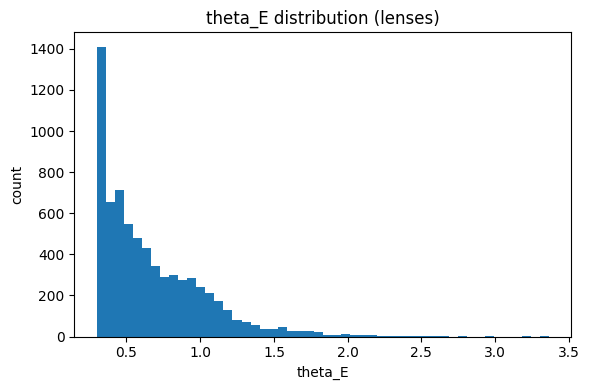

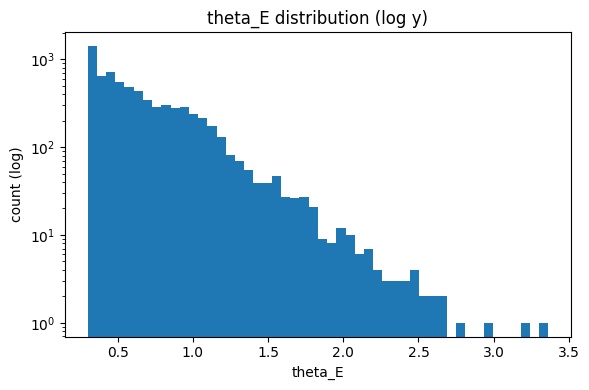

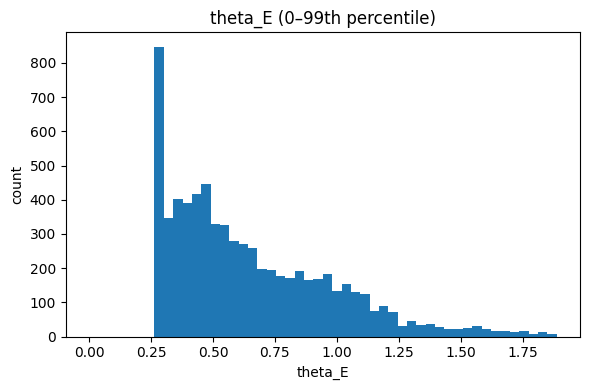

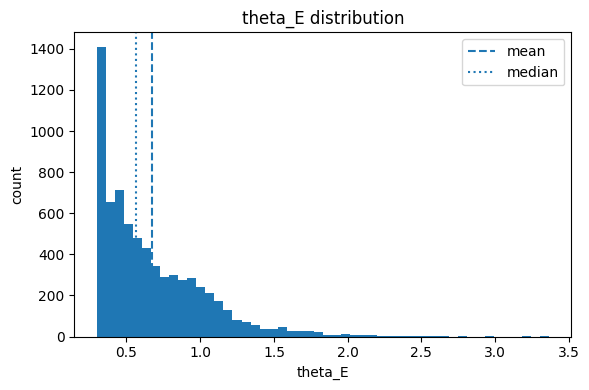


===== lens_n_sersic stats (lenses only) =====
  min   : 2.5
  max   : 2.5
  mean  : 2.5
  median: 2.5


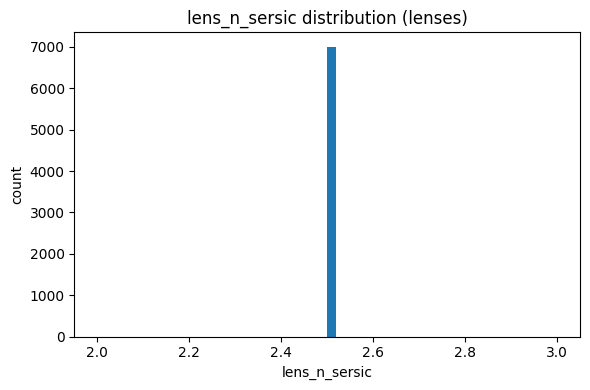

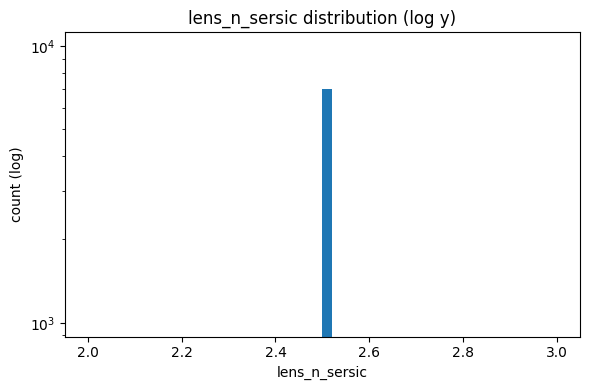

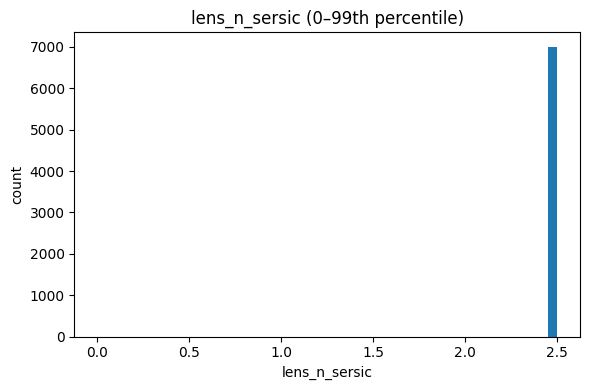

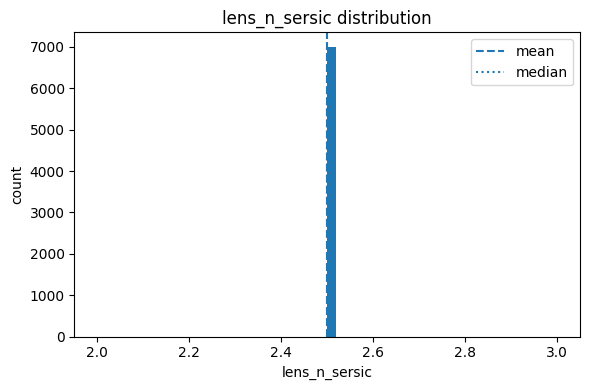


===== lens_radius stats (lenses only) =====
  min   : 0.2
  max   : 4.0
  mean  : 0.4385722912328373
  median: 0.36228999748999713


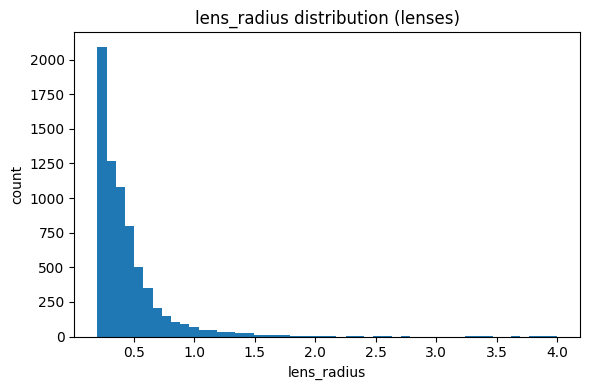

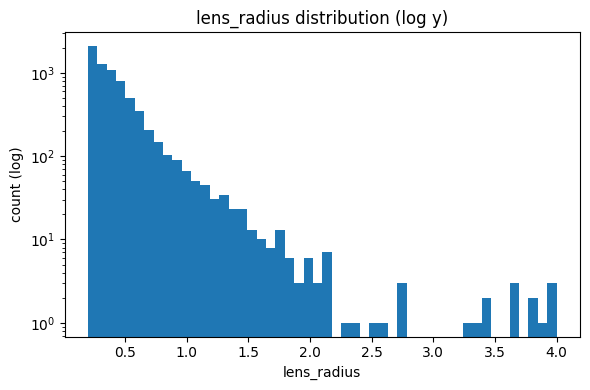

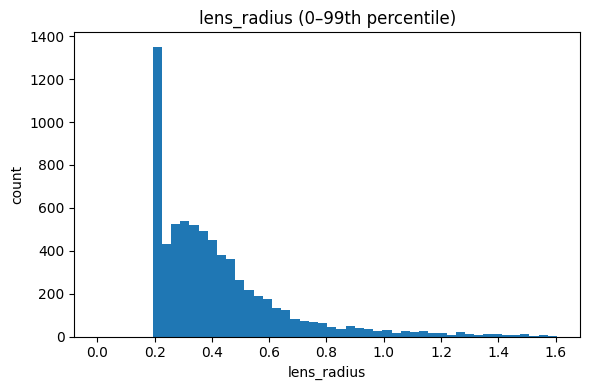

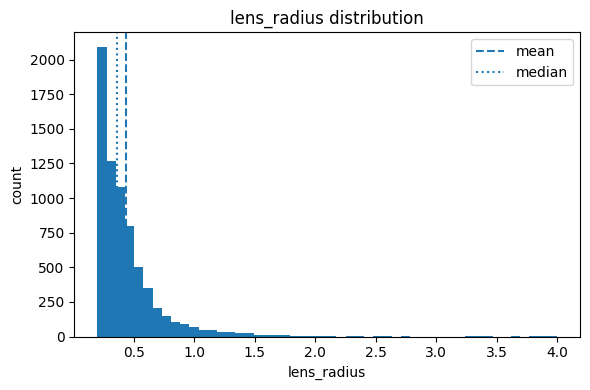

In [6]:
# ----------------------------
# Cell: regression target distribution diagnostics (LENSES ONLY)
# ----------------------------
import matplotlib.pyplot as plt
import numpy as np

targets = [
    "theta_E",
    "lens_n_sersic",
    "lens_radius",
]

for col in targets:
    values = train_df.loc[train_df.y == 1, col].values

    print(f"\n===== {col} stats (lenses only) =====")
    print("  min   :", values.min())
    print("  max   :", values.max())
    print("  mean  :", values.mean())
    print("  median:", np.median(values))

    # --- linear histogram ---
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=50)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"{col} distribution (lenses)")
    plt.tight_layout()
    plt.show()

    # --- log count histogram ---
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=50)
    plt.yscale("log")
    plt.xlabel(col)
    plt.ylabel("count (log)")
    plt.title(f"{col} distribution (log y)")
    plt.tight_layout()
    plt.show()

    # --- clipped at 99th percentile ---
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=50, range=(0, np.percentile(values, 99)))
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"{col} (0–99th percentile)")
    plt.tight_layout()
    plt.show()

    # --- mean + median lines ---
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=50)
    plt.axvline(values.mean(), linestyle="--", label="mean")
    plt.axvline(np.median(values), linestyle=":", label="median")
    plt.legend()
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"{col} distribution")
    plt.tight_layout()
    plt.show()

In [7]:
# ----------------------------
# Cell 3 (final): Dataset (per-image norm) + loaders
#                 Strategy 1: keep single channel (F444W = channel index 3)
# ----------------------------
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class LensRadiusNPYDataset(Dataset):
    def __init__(self, df, resize_to=None):
        self.df = df.reset_index(drop=True)
        self.resize_to = resize_to  # None or int

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        x = np.load(row["path"])  # expected (H,W) or (C,H,W) or (H,W,C)

        # ---- ensure (C,H,W) ----
        if x.ndim == 2:
            x = x[None, ...]  # (1,H,W)

        elif x.ndim == 3:
            # if (H,W,C) -> (C,H,W)
            if x.shape[-1] in (1, 4) and x.shape[0] not in (1, 4):
                x = np.transpose(x, (2, 0, 1))

            # keep only channel 3 (F444W)
            if x.shape[0] == 4:
                x = x[3:4, ...]  # (1,H,W)
            elif x.shape[0] == 1:
                pass
            else:
                raise ValueError(f"Unexpected channel count {x.shape[0]} in {row['path']}")

        else:
            raise ValueError(f"Unexpected shape {x.shape} for {row['path']}")

        x = torch.from_numpy(x).float()  # (1,H,W)

        # optional resize
        if self.resize_to is not None:
            x = F.interpolate(
                x.unsqueeze(0),
                size=(self.resize_to, self.resize_to),
                mode="bilinear",
                align_corners=False
            ).squeeze(0)

        # per-image normalization
        m = x.mean()
        s = x.std(unbiased=False).clamp(min=1e-6)
        x = (x - m) / s

        y = torch.tensor(float(row["y"]), dtype=torch.float32)                 # 0/1
        r = torch.tensor(float(row["theta_E"]), dtype=torch.float32)           # theta_E or 0
        ser = torch.tensor(float(row["lens_n_sersic"]), dtype=torch.float32)   # NEW: sersic or 0
        lens_r = torch.tensor(float(row["lens_radius"]), dtype=torch.float32)  # NEW: lens_radius or 0

        # keep masks if you like (useful for lens-only metrics)
        r_mask = y  # 1 if lens else 0

        return x, y, r, ser, lens_r, r_mask   # NEW: extra outputs

# ----------------------------
# Build datasets + loaders
# ----------------------------
resize_to = None  # set to 125 or 384 if you want fixed size

train_ds = LensRadiusNPYDataset(train_df, resize_to=resize_to)
val_ds   = LensRadiusNPYDataset(val_df,   resize_to=resize_to)
test_ds  = LensRadiusNPYDataset(test_df,  resize_to=resize_to)

BATCH_SIZE = 128
NUM_WORKERS = 4  # set to 0 if dataloader hangs on NERSC nodes

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
)

# ----------------------------
# Sanity check
# ----------------------------
xb, yb, rb, serb, lensrb, mb = next(iter(train_loader))
print("batch x:", xb.shape)      # expect (B,1,H,W)
print("y mean:", yb.mean().item())
print("theta_E mean (lenses only):", rb[mb.bool()].mean().item() if mb.sum() > 0 else "n/a")
print("sersic unique (lenses only):", torch.unique(serb[mb.bool()])[:10] if mb.sum() > 0 else "n/a")
print("lens_radius mean (lenses only):", lensrb[mb.bool()].mean().item() if mb.sum() > 0 else "n/a")

batch x: torch.Size([128, 1, 300, 300])
y mean: 0.4921875
theta_E mean (lenses only): 0.6661892533302307
sersic unique (lenses only): tensor([2.5000])
lens_radius mean (lenses only): 0.5122672915458679


In [8]:
# ----------------------------
# Cell 4 (fixed): Build model + DataParallel + BCE pos_weight + AdaBelief
# ----------------------------
import torch
import torch.nn as nn
from collections import Counter
from adabelief_pytorch import AdaBelief

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BACKBONE = "efficientnet_v2_s"
PRETRAINED = True  # set True only if you KNOW torchvision weights are cached/available on compute nodes

model = LensRadiusEffNetV2(
    backbone=BACKBONE,
    in_channels=1,
    hidden=256,
    pretrained=PRETRAINED,
    add_noise=True
)

# DataParallel (only if multiple GPUs visible to this process)
if torch.cuda.device_count() > 1:
    print("Using DataParallel with", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)

model = model.to(device)

# --- Class counts from train_df ---
counts = Counter(train_df["y"].tolist())
n_neg = counts.get(0, 0)
n_pos = counts.get(1, 0)
pos_weight_cls = torch.tensor([n_neg / max(n_pos, 1)], dtype=torch.float32, device=device)

print("class counts:", counts, "pos_weight:", float(pos_weight_cls.item()))

# --- Classification loss ---
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight_cls)

# --- Regression loss (masked later) ---
reg = nn.SmoothL1Loss(reduction="none")

# Loss weights
lambda_thetaE   = 1.0
lambda_lensrad  = 1.0
lambda_sersic   = 0.01

optimizer = AdaBelief(
    model.parameters(),
    lr=3e-4,
    eps=1e-8,
    betas=(0.9, 0.999),
    weight_decay=1e-5,
    rectify=True,
    print_change_log=False
)

Using DataParallel with 4 GPUs
class counts: Counter({0: 7000, 1: 7000}) pos_weight: 1.0
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [9]:
# ----------------------------
# Cell 5 (fixed): Train + Val loop (BCE + masked SmoothL1) + best checkpoint
# ----------------------------
import os
import numpy as np
import torch
from tqdm import tqdm

SAVE_DIR = "models/models_effnetv2_s_multihead"
os.makedirs(SAVE_DIR, exist_ok=True)

EPOCHS = 200
patience = 0
max_patience = 20
best_val_loss = float("inf")
best_path = os.path.join(SAVE_DIR, f"best_{BACKBONE}.pth")

def unwrap(m):
    return m.module if isinstance(m, torch.nn.DataParallel) else m

def run_one_epoch(model, loader, train: bool):
    model.train() if train else model.eval()

    total_loss = 0.0
    total_cls  = 0.0

    # masked regression accumulation (lenses only, for logging)
    total_thetaE = 0.0
    total_ser    = 0.0
    total_lensr  = 0.0
    n_reg        = 0  # number of lens samples contributing to reg loss

    # metrics
    correct = 0
    n_total = 0

    logits_all = []
    y_all = []

    pbar = tqdm(loader, desc=("train" if train else "val"), leave=False)
    for x, y, r, ser, lens_r, r_mask in pbar:
        x = x.to(device, non_blocking=True)                     # (B,1,H,W)
        y = y.to(device, non_blocking=True).float()             # (B,)
        r = r.to(device, non_blocking=True).float()             # (B,)
        ser = ser.to(device, non_blocking=True).float()         # (B,)
        lens_r = lens_r.to(device, non_blocking=True).float()   # (B,)
        r_mask = r_mask.to(device, non_blocking=True).float()   # (B,)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            out = model(x)

            # support either dict-return model or tuple-return model
            if isinstance(out, dict):
                lens_logit = out["lens_logit"]
                r_pred     = out["r_pred"]
                ser_pred   = out["ser_pred"]
                lensr_pred = out["lensr_pred"]
            else:
                lens_logit, r_pred, ser_pred, lensr_pred = out

            cls_loss = bce(lens_logit, y)

            # --- masked regression: only compute on lenses ---
            mask = (r_mask > 0.0)
            n_reg_batch = int(mask.sum().item())

            if n_reg_batch > 0:
                # reg returns per-sample loss when reduction="none"
                thetaE_loss = reg(r_pred[mask], r[mask]).mean()
                ser_loss    = reg(ser_pred[mask], ser[mask]).mean()
                lensr_loss  = reg(lensr_pred[mask], lens_r[mask]).mean()
            else:
                thetaE_loss = torch.zeros((), device=x.device, dtype=cls_loss.dtype)
                ser_loss    = torch.zeros((), device=x.device, dtype=cls_loss.dtype)
                lensr_loss  = torch.zeros((), device=x.device, dtype=cls_loss.dtype)

            loss = (
                cls_loss
                + lambda_thetaE  * thetaE_loss
                + lambda_sersic  * ser_loss
                + lambda_lensrad * lensr_loss
            )

            if train:
                loss.backward()
                optimizer.step()

        bs = int(x.size(0))
        total_loss += float(loss.item()) * bs
        total_cls  += float(cls_loss.item()) * bs

        if n_reg_batch > 0:
            # for logging: accumulate mean losses * count
            total_thetaE += float(thetaE_loss.item()) * n_reg_batch
            total_ser    += float(ser_loss.item())    * n_reg_batch
            total_lensr  += float(lensr_loss.item())  * n_reg_batch
            n_reg        += n_reg_batch

        preds = (lens_logit.detach() > 0).long()
        correct += int((preds == y.long()).sum().item())
        n_total += bs

        logits_all.append(lens_logit.detach().cpu())
        y_all.append(y.detach().cpu())

        pbar.set_postfix({
            "loss": total_loss / max(n_total, 1),
            "cls":  total_cls  / max(n_total, 1),
            "r":    (total_thetaE / max(n_reg, 1)) if n_reg > 0 else 0.0,
            "ser":  (total_ser    / max(n_reg, 1)) if n_reg > 0 else 0.0,
            "lr":   (total_lensr  / max(n_reg, 1)) if n_reg > 0 else 0.0,
            "acc":  correct / max(n_total, 1),
            "nreg": n_reg
        })

    avg_loss = total_loss / max(n_total, 1)
    avg_cls  = total_cls  / max(n_total, 1)
    avg_thetaE = (total_thetaE / n_reg) if n_reg > 0 else 0.0
    avg_ser    = (total_ser    / n_reg) if n_reg > 0 else 0.0
    avg_lensr  = (total_lensr  / n_reg) if n_reg > 0 else 0.0
    acc      = correct / max(n_total, 1)

    logits_all = torch.cat(logits_all, dim=0)
    y_all      = torch.cat(y_all, dim=0)

    return avg_loss, avg_cls, avg_thetaE, avg_ser, avg_lensr, acc, logits_all, y_all

history = {
    "train_loss": [], "train_cls": [], "train_r": [], "train_ser": [], "train_lensr": [], "train_acc": [],
    "val_loss":   [], "val_cls":   [], "val_r":   [], "val_ser":   [], "val_lensr":   [], "val_acc":   [],
}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_cls, tr_r, tr_ser, tr_lensr, tr_acc, _, _ = run_one_epoch(model, train_loader, train=True)
    va_loss, va_cls, va_r, va_ser, va_lensr, va_acc, va_logits, va_y = run_one_epoch(model, val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_cls"].append(tr_cls)
    history["train_r"].append(tr_r)
    history["train_ser"].append(tr_ser)
    history["train_lensr"].append(tr_lensr)
    history["train_acc"].append(tr_acc)

    history["val_loss"].append(va_loss)
    history["val_cls"].append(va_cls)
    history["val_r"].append(va_r)
    history["val_ser"].append(va_ser)
    history["val_lensr"].append(va_lensr)
    history["val_acc"].append(va_acc)

    print(
        f"Epoch {epoch:03d}/{EPOCHS} | "
        f"train loss {tr_loss:.4f} (cls {tr_cls:.4f}, r {tr_r:.4f}, ser {tr_ser:.4f}, lr {tr_lensr:.4f}) acc {tr_acc:.4f} | "
        f"val loss {va_loss:.4f} (cls {va_cls:.4f}, r {va_r:.4f}, ser {va_ser:.4f}, lr {va_lensr:.4f}) acc {va_acc:.4f}"
    )

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(
            {
                "epoch": epoch,
                "backbone": BACKBONE,
                "model_state": unwrap(model).state_dict(),
                "optimizer_state": optimizer.state_dict(),
            },
            best_path
        )
        patience = 0
        print("  ✅ saved best:", best_path)
    else:
        patience += 1
        print("Patience:", patience)
        if patience >= max_patience:
            break

print("Best val loss:", best_val_loss, "at:", best_path)

Epoch 001/200 | train loss 0.8401 (cls 0.6924, r 0.0644, ser 1.3026, lr 0.0704) acc 0.5054 | val loss 0.8429 (cls 0.6918, r 0.0713, ser 1.3006, lr 0.0665) acc 0.4987
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 002/200 | train loss 0.8099 (cls 0.6844, r 0.0628, ser 1.2914, lr 0.0495) acc 0.6413 | val loss 0.8159 (cls 0.6807, r 0.0702, ser 1.2900, lr 0.0517) acc 0.6047
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 003/200 | train loss 0.6119 (cls 0.4973, r 0.0604, ser 1.2664, lr 0.0416) acc 0.8338 | val loss 0.4448 (cls 0.3193, r 0.0677, ser 1.2525, lr 0.0449) acc 0.9317
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 004/200 | train loss 0.2779 (cls 0.1688, r 0.0557, ser 1.2160, lr 0.0412) acc 0.9451 | val loss 0.2960 (cls 0.1764, r 0.0620, ser 1.1961, lr 0.0452) acc 0.9650
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 005/200 | train loss 0.1831 (cls 0.0947, r 0.0364, ser 1.1339, lr 0.0410) acc 0.9680 | val loss 0.1837 (cls 0.0855, r 0.0426, ser 1.0852, lr 0.0444) acc 0.9790
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 006/200 | train loss 0.1368 (cls 0.0627, r 0.0234, ser 0.9757, lr 0.0408) acc 0.9789 | val loss 0.1909 (cls 0.1009, r 0.0378, ser 0.8436, lr 0.0433) acc 0.9600
Patience: 1


Epoch 007/200 | train loss 0.1123 (cls 0.0468, r 0.0188, ser 0.6018, lr 0.0406) acc 0.9833 | val loss 0.1778 (cls 0.0994, r 0.0304, ser 0.4264, lr 0.0433) acc 0.9717
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 008/200 | train loss 0.0955 (cls 0.0371, r 0.0162, ser 0.1816, lr 0.0403) acc 0.9879 | val loss 0.1039 (cls 0.0411, r 0.0181, ser 0.1464, lr 0.0428) acc 0.9860
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 009/200 | train loss 0.0818 (cls 0.0264, r 0.0144, ser 0.1013, lr 0.0401) acc 0.9909 | val loss 0.1039 (cls 0.0402, r 0.0198, ser 0.0946, lr 0.0425) acc 0.9860
Patience: 1


Epoch 010/200 | train loss 0.0827 (cls 0.0282, r 0.0139, ser 0.0905, lr 0.0398) acc 0.9901 | val loss 0.1256 (cls 0.0460, r 0.0355, ser 0.0924, lr 0.0427) acc 0.9827
Patience: 2


Epoch 011/200 | train loss 0.0791 (cls 0.0258, r 0.0127, ser 0.0825, lr 0.0397) acc 0.9914 | val loss 0.0828 (cls 0.0263, r 0.0124, ser 0.0585, lr 0.0430) acc 0.9920
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 012/200 | train loss 0.0674 (cls 0.0157, r 0.0112, ser 0.0662, lr 0.0397) acc 0.9943 | val loss 0.1029 (cls 0.0382, r 0.0209, ser 0.0806, lr 0.0425) acc 0.9890
Patience: 1


Epoch 013/200 | train loss 0.0648 (cls 0.0137, r 0.0111, ser 0.0648, lr 0.0392) acc 0.9957 | val loss 0.0942 (cls 0.0313, r 0.0196, ser 0.0619, lr 0.0422) acc 0.9897
Patience: 2


Epoch 014/200 | train loss 0.0636 (cls 0.0128, r 0.0108, ser 0.0589, lr 0.0391) acc 0.9954 | val loss 0.0860 (cls 0.0307, r 0.0120, ser 0.0379, lr 0.0424) acc 0.9900
Patience: 3


Epoch 015/200 | train loss 0.0611 (cls 0.0118, r 0.0099, ser 0.0527, lr 0.0389) acc 0.9964 | val loss 0.0850 (cls 0.0283, r 0.0135, ser 0.0536, lr 0.0421) acc 0.9897
Patience: 4


Epoch 016/200 | train loss 0.0569 (cls 0.0084, r 0.0092, ser 0.0451, lr 0.0387) acc 0.9969 | val loss 0.0862 (cls 0.0270, r 0.0161, ser 0.0349, lr 0.0422) acc 0.9900
Patience: 5


Epoch 017/200 | train loss 0.0560 (cls 0.0080, r 0.0092, ser 0.0454, lr 0.0385) acc 0.9974 | val loss 0.0996 (cls 0.0392, r 0.0170, ser 0.0546, lr 0.0423) acc 0.9883
Patience: 6


Epoch 018/200 | train loss 0.0548 (cls 0.0073, r 0.0089, ser 0.0425, lr 0.0383) acc 0.9978 | val loss 0.0864 (cls 0.0286, r 0.0147, ser 0.0573, lr 0.0421) acc 0.9910
Patience: 7


Epoch 019/200 | train loss 0.0536 (cls 0.0070, r 0.0087, ser 0.0435, lr 0.0378) acc 0.9979 | val loss 0.0894 (cls 0.0346, r 0.0111, ser 0.0470, lr 0.0426) acc 0.9903
Patience: 8


Epoch 020/200 | train loss 0.0527 (cls 0.0059, r 0.0086, ser 0.0391, lr 0.0379) acc 0.9981 | val loss 0.0810 (cls 0.0244, r 0.0136, ser 0.0365, lr 0.0421) acc 0.9923
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 021/200 | train loss 0.0565 (cls 0.0098, r 0.0082, ser 0.0420, lr 0.0375) acc 0.9974 | val loss 0.0967 (cls 0.0417, r 0.0118, ser 0.0628, lr 0.0421) acc 0.9880
Patience: 1


Epoch 022/200 | train loss 0.0513 (cls 0.0052, r 0.0082, ser 0.0383, lr 0.0373) acc 0.9984 | val loss 0.1013 (cls 0.0472, r 0.0111, ser 0.0517, lr 0.0420) acc 0.9853
Patience: 2


Epoch 023/200 | train loss 0.0482 (cls 0.0032, r 0.0078, ser 0.0310, lr 0.0366) acc 0.9990 | val loss 0.0919 (cls 0.0369, r 0.0119, ser 0.0443, lr 0.0421) acc 0.9900
Patience: 3


Epoch 024/200 | train loss 0.0499 (cls 0.0058, r 0.0075, ser 0.0309, lr 0.0362) acc 0.9981 | val loss 0.0964 (cls 0.0376, r 0.0149, ser 0.0595, lr 0.0428) acc 0.9890
Patience: 4


Epoch 025/200 | train loss 0.0475 (cls 0.0039, r 0.0073, ser 0.0309, lr 0.0360) acc 0.9991 | val loss 0.0838 (cls 0.0282, r 0.0122, ser 0.0315, lr 0.0425) acc 0.9910
Patience: 5


Epoch 026/200 | train loss 0.0451 (cls 0.0024, r 0.0072, ser 0.0264, lr 0.0350) acc 0.9994 | val loss 0.0908 (cls 0.0315, r 0.0151, ser 0.0351, lr 0.0432) acc 0.9903
Patience: 6


Epoch 027/200 | train loss 0.0469 (cls 0.0052, r 0.0070, ser 0.0276, lr 0.0346) acc 0.9982 | val loss 0.0732 (cls 0.0189, r 0.0098, ser 0.0344, lr 0.0436) acc 0.9947
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 028/200 | train loss 0.0446 (cls 0.0041, r 0.0068, ser 0.0275, lr 0.0335) acc 0.9986 | val loss 0.1293 (cls 0.0736, r 0.0117, ser 0.0587, lr 0.0429) acc 0.9763
Patience: 1


Epoch 029/200 | train loss 0.0443 (cls 0.0035, r 0.0069, ser 0.0282, lr 0.0335) acc 0.9991 | val loss 0.0963 (cls 0.0411, r 0.0110, ser 0.0467, lr 0.0432) acc 0.9880
Patience: 2


Epoch 030/200 | train loss 0.0408 (cls 0.0028, r 0.0066, ser 0.0240, lr 0.0313) acc 0.9990 | val loss 0.0720 (cls 0.0208, r 0.0067, ser 0.0408, lr 0.0435) acc 0.9940
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 031/200 | train loss 0.0403 (cls 0.0024, r 0.0067, ser 0.0220, lr 0.0311) acc 0.9993 | val loss 0.0682 (cls 0.0166, r 0.0069, ser 0.0223, lr 0.0439) acc 0.9950
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 032/200 | train loss 0.0375 (cls 0.0017, r 0.0064, ser 0.0208, lr 0.0290) acc 0.9995 | val loss 0.0708 (cls 0.0214, r 0.0073, ser 0.0394, lr 0.0413) acc 0.9933
Patience: 1


Epoch 033/200 | train loss 0.0350 (cls 0.0010, r 0.0063, ser 0.0192, lr 0.0273) acc 0.9997 | val loss 0.0691 (cls 0.0162, r 0.0094, ser 0.0304, lr 0.0427) acc 0.9950
Patience: 2


Epoch 034/200 | train loss 0.0334 (cls 0.0009, r 0.0061, ser 0.0201, lr 0.0261) acc 0.9997 | val loss 0.0716 (cls 0.0171, r 0.0070, ser 0.0347, lr 0.0467) acc 0.9943
Patience: 3


Epoch 035/200 | train loss 0.0358 (cls 0.0033, r 0.0061, ser 0.0230, lr 0.0260) acc 0.9990 | val loss 0.1070 (cls 0.0500, r 0.0104, ser 0.0516, lr 0.0456) acc 0.9853
Patience: 4


Epoch 036/200 | train loss 0.0355 (cls 0.0021, r 0.0062, ser 0.0216, lr 0.0268) acc 0.9996 | val loss 0.0730 (cls 0.0215, r 0.0089, ser 0.0319, lr 0.0418) acc 0.9930
Patience: 5


Epoch 037/200 | train loss 0.0319 (cls 0.0018, r 0.0060, ser 0.0171, lr 0.0241) acc 0.9993 | val loss 0.0816 (cls 0.0309, r 0.0070, ser 0.0232, lr 0.0430) acc 0.9903
Patience: 6


Epoch 038/200 | train loss 0.0369 (cls 0.0048, r 0.0063, ser 0.0201, lr 0.0255) acc 0.9984 | val loss 0.0889 (cls 0.0334, r 0.0093, ser 0.0322, lr 0.0454) acc 0.9880
Patience: 7


Epoch 039/200 | train loss 0.0348 (cls 0.0036, r 0.0061, ser 0.0224, lr 0.0248) acc 0.9991 | val loss 0.0827 (cls 0.0326, r 0.0074, ser 0.0247, lr 0.0421) acc 0.9913
Patience: 8


Epoch 040/200 | train loss 0.0298 (cls 0.0019, r 0.0058, ser 0.0207, lr 0.0218) acc 0.9993 | val loss 0.0849 (cls 0.0296, r 0.0087, ser 0.0301, lr 0.0459) acc 0.9917
Patience: 9


Epoch 041/200 | train loss 0.0283 (cls 0.0022, r 0.0058, ser 0.0201, lr 0.0201) acc 0.9994 | val loss 0.0687 (cls 0.0201, r 0.0068, ser 0.0296, lr 0.0410) acc 0.9947
Patience: 10


Epoch 042/200 | train loss 0.0268 (cls 0.0015, r 0.0056, ser 0.0193, lr 0.0196) acc 0.9996 | val loss 0.0730 (cls 0.0216, r 0.0078, ser 0.0270, lr 0.0428) acc 0.9937
Patience: 11


Epoch 043/200 | train loss 0.0269 (cls 0.0028, r 0.0055, ser 0.0175, lr 0.0183) acc 0.9995 | val loss 0.0672 (cls 0.0200, r 0.0062, ser 0.0224, lr 0.0404) acc 0.9950
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 044/200 | train loss 0.0341 (cls 0.0071, r 0.0063, ser 0.0243, lr 0.0205) acc 0.9980 | val loss 0.0777 (cls 0.0260, r 0.0100, ser 0.0436, lr 0.0407) acc 0.9900
Patience: 1


Epoch 045/200 | train loss 0.0266 (cls 0.0017, r 0.0055, ser 0.0178, lr 0.0193) acc 0.9997 | val loss 0.0700 (cls 0.0198, r 0.0083, ser 0.0262, lr 0.0411) acc 0.9947
Patience: 2


Epoch 046/200 | train loss 0.0280 (cls 0.0039, r 0.0056, ser 0.0182, lr 0.0182) acc 0.9989 | val loss 0.0740 (cls 0.0217, r 0.0083, ser 0.0251, lr 0.0432) acc 0.9927
Patience: 3


Epoch 047/200 | train loss 0.0235 (cls 0.0013, r 0.0051, ser 0.0175, lr 0.0169) acc 0.9997 | val loss 0.0706 (cls 0.0202, r 0.0077, ser 0.0211, lr 0.0418) acc 0.9940
Patience: 4


Epoch 048/200 | train loss 0.0220 (cls 0.0007, r 0.0049, ser 0.0156, lr 0.0163) acc 0.9998 | val loss 0.0624 (cls 0.0159, r 0.0070, ser 0.0160, lr 0.0389) acc 0.9947
  ✅ saved best: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


Epoch 049/200 | train loss 0.0208 (cls 0.0009, r 0.0045, ser 0.0152, lr 0.0152) acc 0.9997 | val loss 0.0789 (cls 0.0249, r 0.0110, ser 0.0287, lr 0.0422) acc 0.9923
Patience: 1


Epoch 050/200 | train loss 0.0204 (cls 0.0010, r 0.0045, ser 0.0155, lr 0.0148) acc 0.9999 | val loss 0.0753 (cls 0.0244, r 0.0091, ser 0.0218, lr 0.0411) acc 0.9917
Patience: 2


Epoch 051/200 | train loss 0.0190 (cls 0.0003, r 0.0041, ser 0.0145, lr 0.0145) acc 0.9999 | val loss 0.0713 (cls 0.0206, r 0.0092, ser 0.0234, lr 0.0407) acc 0.9943
Patience: 3


Epoch 052/200 | train loss 0.0184 (cls 0.0007, r 0.0040, ser 0.0143, lr 0.0135) acc 0.9999 | val loss 0.0786 (cls 0.0270, r 0.0105, ser 0.0181, lr 0.0404) acc 0.9937
Patience: 4


Epoch 053/200 | train loss 0.0192 (cls 0.0017, r 0.0038, ser 0.0147, lr 0.0136) acc 0.9995 | val loss 0.0680 (cls 0.0195, r 0.0071, ser 0.0213, lr 0.0407) acc 0.9947
Patience: 5


Epoch 054/200 | train loss 0.0182 (cls 0.0014, r 0.0038, ser 0.0150, lr 0.0128) acc 0.9995 | val loss 0.0704 (cls 0.0208, r 0.0068, ser 0.0312, lr 0.0419) acc 0.9927
Patience: 6


Epoch 055/200 | train loss 0.0160 (cls 0.0004, r 0.0034, ser 0.0132, lr 0.0121) acc 0.9999 | val loss 0.0724 (cls 0.0234, r 0.0074, ser 0.0270, lr 0.0408) acc 0.9927
Patience: 7


Epoch 056/200 | train loss 0.0166 (cls 0.0013, r 0.0035, ser 0.0129, lr 0.0118) acc 0.9996 | val loss 0.0752 (cls 0.0244, r 0.0078, ser 0.0256, lr 0.0422) acc 0.9910
Patience: 8


Epoch 057/200 | train loss 0.0158 (cls 0.0003, r 0.0035, ser 0.0127, lr 0.0118) acc 1.0000 | val loss 0.0638 (cls 0.0163, r 0.0064, ser 0.0147, lr 0.0404) acc 0.9957
Patience: 9


Epoch 058/200 | train loss 0.0148 (cls 0.0009, r 0.0031, ser 0.0121, lr 0.0106) acc 0.9998 | val loss 0.0639 (cls 0.0161, r 0.0064, ser 0.0154, lr 0.0408) acc 0.9957
Patience: 10


Epoch 059/200 | train loss 0.0167 (cls 0.0024, r 0.0034, ser 0.0143, lr 0.0108) acc 0.9991 | val loss 0.0642 (cls 0.0153, r 0.0067, ser 0.0306, lr 0.0415) acc 0.9957
Patience: 11


Epoch 060/200 | train loss 0.0165 (cls 0.0016, r 0.0034, ser 0.0131, lr 0.0113) acc 0.9996 | val loss 0.0633 (cls 0.0156, r 0.0070, ser 0.0199, lr 0.0401) acc 0.9943
Patience: 12


Epoch 061/200 | train loss 0.0155 (cls 0.0023, r 0.0029, ser 0.0131, lr 0.0102) acc 0.9994 | val loss 0.0710 (cls 0.0215, r 0.0074, ser 0.0211, lr 0.0413) acc 0.9920
Patience: 13


Epoch 062/200 | train loss 0.0133 (cls 0.0003, r 0.0030, ser 0.0130, lr 0.0098) acc 1.0000 | val loss 0.0654 (cls 0.0171, r 0.0063, ser 0.0136, lr 0.0414) acc 0.9950
Patience: 14


Epoch 063/200 | train loss 0.0124 (cls 0.0003, r 0.0027, ser 0.0104, lr 0.0093) acc 0.9999 | val loss 0.0820 (cls 0.0342, r 0.0061, ser 0.0061, lr 0.0411) acc 0.9920
Patience: 15


Epoch 064/200 | train loss 0.0118 (cls 0.0002, r 0.0025, ser 0.0107, lr 0.0090) acc 1.0000 | val loss 0.0897 (cls 0.0391, r 0.0074, ser 0.0167, lr 0.0426) acc 0.9870
Patience: 16


Epoch 065/200 | train loss 0.0114 (cls 0.0003, r 0.0024, ser 0.0106, lr 0.0085) acc 0.9999 | val loss 0.0775 (cls 0.0284, r 0.0074, ser 0.0138, lr 0.0411) acc 0.9900
Patience: 17


Epoch 066/200 | train loss 0.0111 (cls 0.0003, r 0.0024, ser 0.0109, lr 0.0083) acc 0.9999 | val loss 0.0894 (cls 0.0389, r 0.0082, ser 0.0186, lr 0.0415) acc 0.9877
Patience: 18


Epoch 067/200 | train loss 0.0114 (cls 0.0003, r 0.0024, ser 0.0108, lr 0.0086) acc 0.9999 | val loss 0.0858 (cls 0.0363, r 0.0073, ser 0.0153, lr 0.0415) acc 0.9883
Patience: 19


Epoch 068/200 | train loss 0.0107 (cls 0.0004, r 0.0024, ser 0.0112, lr 0.0078) acc 0.9998 | val loss 0.0927 (cls 0.0393, r 0.0096, ser 0.0219, lr 0.0430) acc 0.9897
Patience: 20
Best val loss: 0.062413621723651884 at: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth


In [10]:
# # ----------------------------
# # Cell 6 (fixed): Curves + val AUROC + radius sanity check (raw theta_E)
# # ----------------------------
# import numpy as np
# import matplotlib.pyplot as plt
# import torch

# # --- plot curves ---
# epochs = np.arange(1, len(history["train_loss"]) + 1)

# plt.figure()
# plt.plot(epochs, history["train_loss"], label="train_loss")
# plt.plot(epochs, history["val_loss"],   label="val_loss")
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(epochs, history["train_acc"], label="train_acc")
# plt.plot(epochs, history["val_acc"],   label="val_acc")
# plt.xlabel("epoch")
# plt.ylabel("accuracy")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(epochs, history["train_cls"], label="train_cls")
# plt.plot(epochs, history["val_cls"],   label="val_cls")
# plt.xlabel("epoch")
# plt.ylabel("BCE loss")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(epochs, history["train_reg"], label="train_reg")
# plt.plot(epochs, history["val_reg"],   label="val_reg")
# plt.xlabel("epoch")
# plt.ylabel("SmoothL1 loss (theta_E, lenses only)")
# plt.legend()
# plt.show()


# # --- quick val AUROC ---
# val_probs = torch.sigmoid(va_logits).cpu().numpy()
# val_y_np  = va_y.cpu().numpy().astype(np.int32)

# print("val probs range:", float(val_probs.min()), float(val_probs.max()))
# print("val y counts:", {0: int((val_y_np==0).sum()), 1: int((val_y_np==1).sum())})

# try:
#     from sklearn.metrics import roc_auc_score
#     auc = roc_auc_score(val_y_np, val_probs)
#     print("val AUROC:", auc)
# except Exception as e:
#     print("[info] AUROC not computed:", e)


# # --- radius sanity check on a small val batch (only compare where r_mask==1) ---
# model.eval()
# with torch.no_grad():
#     x, y, r_true, r_mask = next(iter(test_loader))
#     x = x.to(device)
#     r_true = r_true.to(device)
#     r_mask = r_mask.to(device)

#     lens_logit, r_pred = model(x)  # r_pred is already in theta_E units (>=0 via softplus)

# mask = (r_mask > 0.5).cpu().numpy()
# r_true_l = r_true.cpu().numpy()[mask]
# r_pred_l = r_pred.detach().cpu().numpy()[mask]

# print("Lens samples in batch:", len(r_true_l))
# print("theta_E true (first 10 lenses):", r_true_l[:10])
# print("theta_E pred (first 10 lenses):", r_pred_l[:10])

# if len(r_true_l) > 0:
#     rel_err = (r_pred_l - r_true_l) / (r_true_l + 1e-8)
#     print("Relative error stats (lenses only):")
#     print(f"  mean: {rel_err.mean(): .4f}")
#     print(f"  std : {rel_err.std(): .4f}")
#     print(f"  min : {rel_err.min(): .4f}")
#     print(f"  max : {rel_err.max(): .4f}")

Loading best model from: models/models_effnetv2_s_multihead/best_efficientnet_v2_s.pth
Loaded epoch: 48


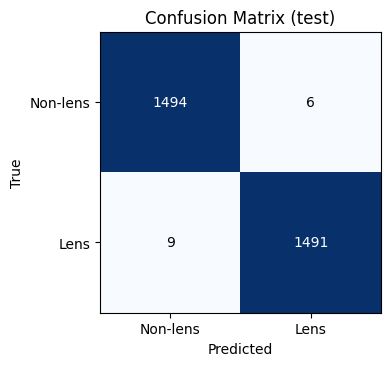

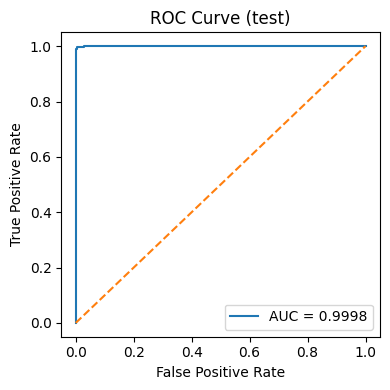

Test AUC: 0.999844
Test accuracy @0.5: 0.995
Counts: lenses = 1500 | non-lenses = 1500

===== theta_E (LENSES) =====
N = 1500
theta_E (LENSES) MAE : 0.06587643176317215
theta_E (LENSES) RMSE: 0.11752935498952866


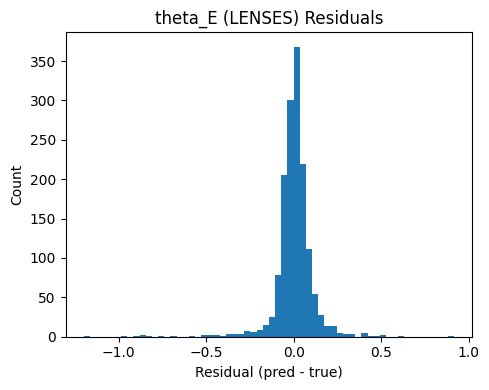

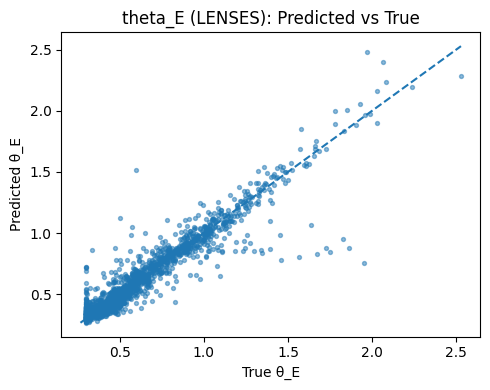

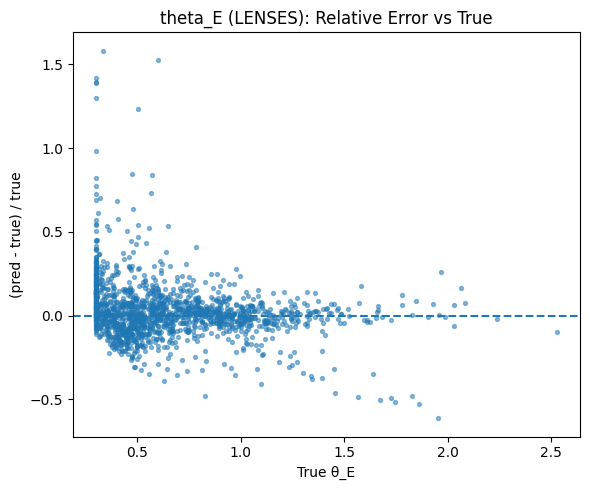

Relative error stats:
  mean:  0.0269
  std :  0.1809
  min : -0.6137
  max :  1.5823
Median relative error: 0.010906567797064781

===== theta_E (NON-LENSES vs 0) =====
N = 1500
theta_E (NON-LENSES vs 0) MAE : 0.8750618696212769
theta_E (NON-LENSES vs 0) RMSE: 0.9646754860877991


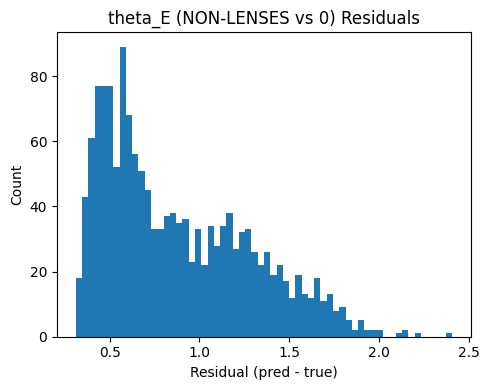

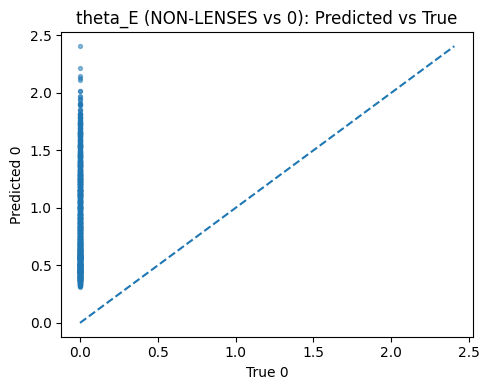

[note] relative error skipped (true values ~ 0)

===== lens_radius (LENSES) =====
N = 1500
lens_radius (LENSES) MAE : 0.17412392795085907
lens_radius (LENSES) RMSE: 0.2751469016075134


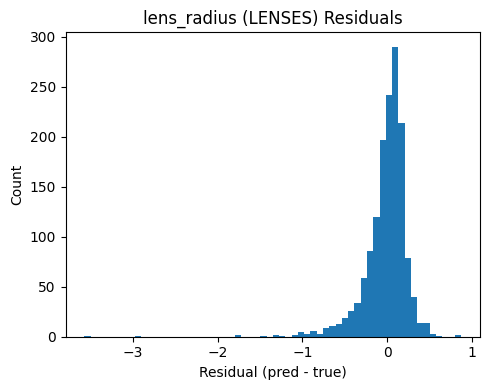

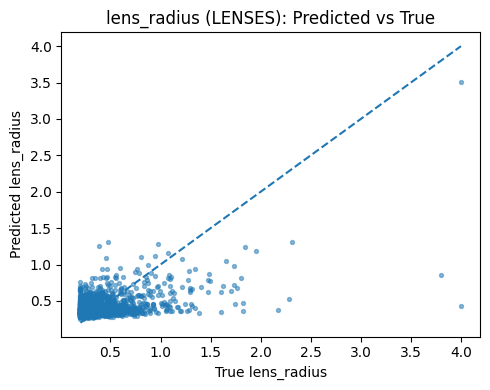

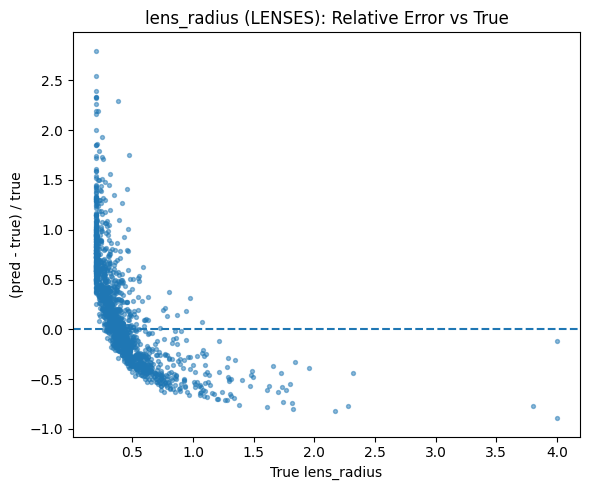

Relative error stats:
  mean:  0.1831
  std :  0.5407
  min : -0.8931
  max :  2.7980
Median relative error: 0.08180386573076248

===== lens_radius (NON-LENSES vs 0) =====
N = 1500
lens_radius (NON-LENSES vs 0) MAE : 0.4154587686061859
lens_radius (NON-LENSES vs 0) RMSE: 0.4218005836009979


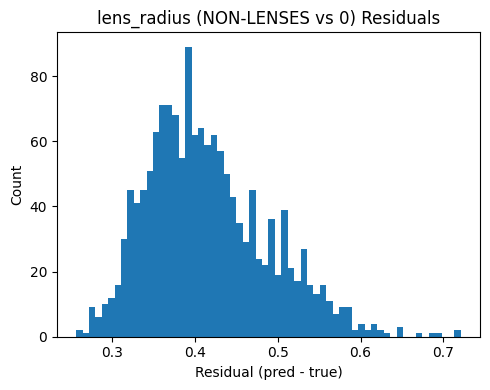

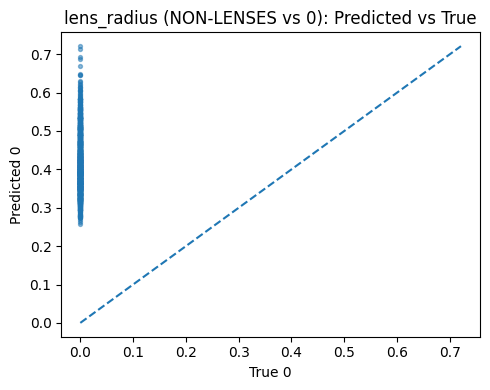

[note] relative error skipped (true values ~ 0)

===== lens_n_sersic (LENSES) =====
N = 1500
lens_n_sersic (LENSES) MAE : 0.13142108917236328
lens_n_sersic (LENSES) RMSE: 0.18573741614818573


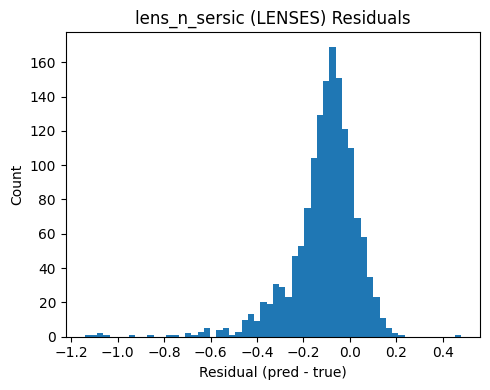

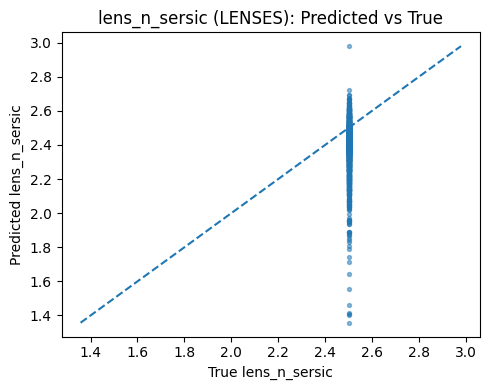

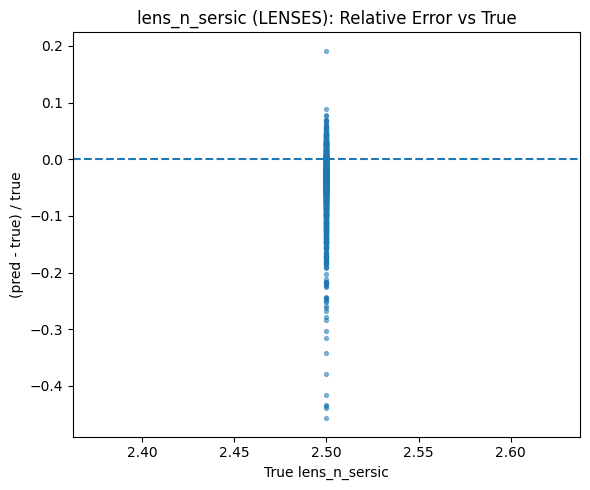

Relative error stats:
  mean: -0.0443
  std :  0.0597
  min : -0.4570
  max :  0.1916
Median relative error: -0.035001181066036224

===== lens_n_sersic (NON-LENSES vs 0) =====
N = 1500
lens_n_sersic (NON-LENSES vs 0) MAE : 1.6010020971298218
lens_n_sersic (NON-LENSES vs 0) RMSE: 1.6114155054092407


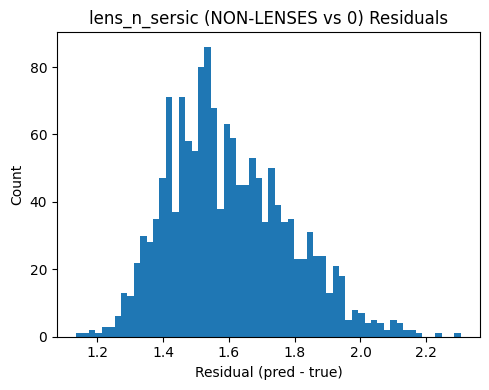

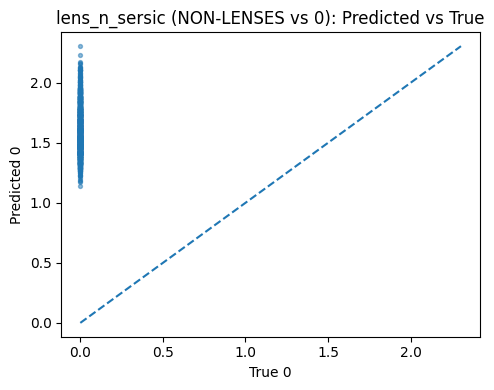

[note] relative error skipped (true values ~ 0)


In [11]:
# ----------------------------
# Cell 7 (updated): Confusion Matrix + ROC + Multi-head Regression Diagnostics (TEST)
#   - Classification: all samples
#   - Regression: lenses (vs true) AND non-lenses (vs 0 baseline)
# ----------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
# ----------------------------
# Load best saved model
# ----------------------------
print("Loading best model from:", best_path)

ckpt = torch.load(best_path, map_location=device)

unwrap(model).load_state_dict(ckpt["model_state"])
model = model.to(device)
model.eval()

print("Loaded epoch:", ckpt.get("epoch", "unknown"))
model.eval()

all_probs   = []
all_y       = []

all_r_pred  = []
all_r_true  = []

all_ser_pred = []
all_ser_true = []

all_lensr_pred = []
all_lensr_true = []

all_mask    = []

with torch.no_grad():
    for x, y, r_true, ser_true, lensr_true, r_mask in test_loader:
        x = x.to(device)
        y = y.to(device).float()

        r_true = r_true.to(device).float()
        ser_true = ser_true.to(device).float()
        lensr_true = lensr_true.to(device).float()

        r_mask = r_mask.to(device).float()  # 1 lens, 0 non-lens

        out = model(x)
        if isinstance(out, dict):
            logits     = out["lens_logit"]
            r_pred     = out["r_pred"]
            ser_pred   = out["ser_pred"]
            lensr_pred = out["lensr_pred"]
        else:
            logits, r_pred, ser_pred, lensr_pred = out

        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu())
        all_y.append(y.cpu())

        all_r_pred.append(r_pred.cpu())
        all_r_true.append(r_true.cpu())

        all_ser_pred.append(ser_pred.cpu())
        all_ser_true.append(ser_true.cpu())

        all_lensr_pred.append(lensr_pred.cpu())
        all_lensr_true.append(lensr_true.cpu())

        all_mask.append(r_mask.cpu())

# --- stack ---
probs  = torch.cat(all_probs).numpy()
y_true = torch.cat(all_y).numpy().astype(int)

r_pred = torch.cat(all_r_pred).numpy()
r_true = torch.cat(all_r_true).numpy()

ser_pred = torch.cat(all_ser_pred).numpy()
ser_true = torch.cat(all_ser_true).numpy()

lensr_pred = torch.cat(all_lensr_pred).numpy()
lensr_true = torch.cat(all_lensr_true).numpy()

mask = torch.cat(all_mask).numpy().astype(int)   # 1 lens, 0 non-lens

# ============================
# Classification: Confusion Matrix (threshold 0.5) + ROC
# ============================
y_pred = (probs >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")

plt.xticks([0,1], ["Non-lens", "Lens"])
plt.yticks([0,1], ["Non-lens", "Lens"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (test)")

# Annotate cells with contrast-aware text color
for (i, j), v in np.ndenumerate(cm):
    color = "white" if v > cm.max() / 2 else "black"
    plt.text(j, i, str(v), ha="center", va="center", color=color)

plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (test)")
plt.legend()
plt.tight_layout()
plt.show()

print("Test AUC:", roc_auc)
print("Test accuracy @0.5:", float((y_pred == y_true).mean()))
print("Counts: lenses =", int(mask.sum()), "| non-lenses =", int((mask == 0).sum()))

# ============================
# Helper: regression metric print + plots
# ============================
def regression_suite(name, pred, true, idx, x_label):
    """
    idx: boolean mask array selecting subset to evaluate
    """
    pred_s = pred[idx]
    true_s = true[idx]
    n = len(true_s)
    print(f"\n===== {name} =====")
    print("N =", n)
    if n == 0:
        print("[warn] empty subset")
        return

    residuals = pred_s - true_s
    mae = float(np.mean(np.abs(residuals)))
    rmse = float(np.sqrt(np.mean(residuals**2)))

    print(f"{name} MAE :", mae)
    print(f"{name} RMSE:", rmse)

    # Residual histogram
    plt.figure(figsize=(5,4))
    plt.hist(residuals, bins=60)
    plt.xlabel("Residual (pred - true)")
    plt.ylabel("Count")
    plt.title(f"{name} Residuals")
    plt.tight_layout()
    plt.show()

    # Pred vs True scatter
    plt.figure(figsize=(5,4))
    plt.scatter(true_s, pred_s, s=8, alpha=0.5)
    lims = [min(true_s.min(), pred_s.min()), max(true_s.max(), pred_s.max())]
    plt.plot(lims, lims, "--")
    plt.xlabel(f"True {x_label}")
    plt.ylabel(f"Predicted {x_label}")
    plt.title(f"{name}: Predicted vs True")
    plt.tight_layout()
    plt.show()

    # Relative error (only meaningful when true != 0)
    if np.any(np.abs(true_s) > 1e-8):
        rel_err = residuals / (true_s + 1e-8)
        plt.figure(figsize=(6,5))
        plt.scatter(true_s, rel_err, s=8, alpha=0.5)
        plt.axhline(0, linestyle="--")
        plt.xlabel(f"True {x_label}")
        plt.ylabel("(pred - true) / true")
        plt.title(f"{name}: Relative Error vs True")
        plt.tight_layout()
        plt.show()

        print("Relative error stats:")
        print(f"  mean: {rel_err.mean(): .4f}")
        print(f"  std : {rel_err.std(): .4f}")
        print(f"  min : {rel_err.min(): .4f}")
        print(f"  max : {rel_err.max(): .4f}")
        print("Median relative error:", float(np.median(rel_err)))
    else:
        print("[note] relative error skipped (true values ~ 0)")

# ============================
# Regression diagnostics
#   Lenses: compare to true
#   Non-lenses: compare to 0 baseline (true already 0 in df)
# ============================

is_lens = (mask == 1)
is_non  = (mask == 0)

# --- theta_E ---
regression_suite("theta_E (LENSES)", r_pred, r_true, is_lens, x_label="θ_E")
regression_suite("theta_E (NON-LENSES vs 0)", r_pred, np.zeros_like(r_pred), is_non, x_label="0")

# --- lens_radius ---
regression_suite("lens_radius (LENSES)", lensr_pred, lensr_true, is_lens, x_label="lens_radius")
regression_suite("lens_radius (NON-LENSES vs 0)", lensr_pred, np.zeros_like(lensr_pred), is_non, x_label="0")

# --- lens_n_sersic ---
# NOTE: in your current catalog this is constant 2.5 for lenses.
regression_suite("lens_n_sersic (LENSES)", ser_pred, ser_true, is_lens, x_label="lens_n_sersic")
regression_suite("lens_n_sersic (NON-LENSES vs 0)", ser_pred, np.zeros_like(ser_pred), is_non, x_label="0")

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def load_raw_single_channel(path):
    x = np.load(path)

    if x.ndim == 2:
        x = x[None, ...]

    elif x.ndim == 3:
        if x.shape[-1] in (1, 4) and x.shape[0] not in (1, 4):
            x = np.transpose(x, (2, 0, 1))

        if x.shape[0] == 4:
            x = x[3:4, ...]
        elif x.shape[0] == 1:
            pass
        else:
            raise ValueError(f"Unexpected channel count {x.shape[0]} in {path}")
    else:
        raise ValueError(f"Unexpected shape {x.shape} for {path}")

    return x[0].astype(np.float32)

def stretch01(img, lo=1, hi=99):
    vmin, vmax = np.percentile(img, [lo, hi])
    img = np.clip(img, vmin, vmax)
    return (img - vmin) / (vmax - vmin + 1e-8)

model.eval()

all_probs  = []
all_y      = []
all_r_pred = []
all_r_true = []
all_r_mask = []
all_idx    = []

with torch.no_grad():
    offset = 0
    for x, y, r_true, r_mask in test_loader:
        bs = x.size(0)
        batch_idx = np.arange(offset, offset + bs)
        offset += bs

        x = x.to(device)
        y = y.to(device).float()
        r_true = r_true.to(device).float()
        r_mask = r_mask.to(device).float()

        logits, r_pred = model(x)
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu())
        all_y.append(y.cpu())
        all_r_pred.append(r_pred.cpu())
        all_r_true.append(r_true.cpu())
        all_r_mask.append(r_mask.cpu())
        all_idx.append(torch.from_numpy(batch_idx))

probs  = torch.cat(all_probs).numpy()
r_pred = torch.cat(all_r_pred).numpy()
r_true = torch.cat(all_r_true).numpy()
r_mask = torch.cat(all_r_mask).numpy().astype(int)
idx_all = torch.cat(all_idx).numpy().astype(int)

mask = (r_mask == 1)
r_pred_l = r_pred[mask]
r_true_l = r_true[mask]
idx_l    = idx_all[mask]

residuals = r_pred_l - r_true_l
abs_err = np.abs(residuals)

k = 10
worst = np.argsort(abs_err)[-k:][::-1]

plt.figure(figsize=(18, 7))

for i, w in enumerate(worst):
    ds_idx = int(idx_l[w])
    row = test_ds.df.iloc[ds_idx]
    path = row["path"]

    img = load_raw_single_channel(path)
    img_disp = stretch01(img)

    plt.subplot(2, 5, i+1)   # <-- 2 rows, 5 cols
    plt.imshow(img_disp, cmap="gray")
    plt.axis("off")
    plt.title(f"T:{r_true_l[w]:.2f}\nP:{r_pred_l[w]:.2f}\nErr:{residuals[w]:+.2f}")

plt.suptitle(f"Worst {k} Einstein Radius Predictions (RAW display, test lenses)")
plt.tight_layout()
plt.show()

print(f"\nPaths for worst {k}:")
for w in worst:
    ds_idx = int(idx_l[w])
    print(test_ds.df.iloc[ds_idx]["path"])

ValueError: too many values to unpack (expected 4)

In [ ]:
# ==============================
# Worst 10 by Relative Error
# ==============================

rel_err = (r_pred_l - r_true_l) / (r_true_l + 1e-8)
abs_rel_err = np.abs(rel_err)

k = 10
worst_rel = np.argsort(abs_rel_err)[-k:][::-1]

plt.figure(figsize=(18, 7))

for i, w in enumerate(worst_rel):
    ds_idx = int(idx_l[w])
    row = test_ds.df.iloc[ds_idx]
    path = row["path"]

    img = load_raw_single_channel(path)
    img_disp = stretch01(img)

    plt.subplot(2, 5, i+1)
    plt.imshow(img_disp, cmap="gray")
    plt.axis("off")
    plt.title(
        f"T:{r_true_l[w]:.2f}\n"
        f"P:{r_pred_l[w]:.2f}\n"
        f"RelErr:{rel_err[w]:+.2f}"
    )

plt.suptitle(f"Worst {k} Einstein Radius Predictions (by |relative error|, test lenses)")
plt.tight_layout()
plt.show()

print(f"\nPaths for worst {k} by relative error:")
for w in worst_rel:
    ds_idx = int(idx_l[w])
    print(test_ds.df.iloc[ds_idx]["path"])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

paths = [
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_008569.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_000815.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_008590.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_003434.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_000386.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_004911.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_000393.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_002553.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_006430.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_008163.npy",
]

import math

n = len(paths)
cols = 5
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 4, rows * 4))

for i, path in enumerate(paths):
    x = np.load(path)

    print(f"\n{path}")
    print("shape:", x.shape)
    print("min/max/mean/std:", x.min(), x.max(), x.mean(), x.std())

    if x.ndim == 3 and x.shape[-1] == 4 and x.shape[0] != 4:
        x = np.transpose(x, (2, 0, 1))

    if x.ndim == 3 and x.shape[0] == 4:
        img = x[3]
    elif x.ndim == 2:
        img = x
    else:
        raise ValueError(f"Unexpected shape: {x.shape}")

    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(path.split("/")[-1], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

paths = [
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_006430.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_007574.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_001622.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_004911.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_001358.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_002267.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_009159.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_005483.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_002258.npy",
"/global/cfs/projectdirs/deepsrch/gozalias/team_shared_jwst_lens_sim/jwst_lens_sim_10k_20251128_072744_job_45781953/npy/cosmos_lens_008163.npy",
]

def ensure_chw(x):
    if x.ndim == 3 and x.shape[-1] == 4 and x.shape[0] != 4:
        return np.transpose(x, (2, 0, 1))
    return x

n = len(paths)
cols = 5
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 4, rows * 4))

for i, path in enumerate(paths):
    x = np.load(path)
    x = ensure_chw(x)

    print("\n", path.split("/")[-1])
    print("shape:", x.shape)
    print("min/max/mean/std:", x.min(), x.max(), x.mean(), x.std())

    if x.ndim == 3 and x.shape[0] == 4:
        img = x[3]  # F444W
    elif x.ndim == 2:
        img = x
    else:
        raise ValueError(f"Unexpected shape: {x.shape}")

    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap="gray", vmin=img.min(), vmax=img.max())
    plt.title(path.split("/")[-1], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _to_chw(x):
    """Return image as (C,H,W). Accepts (C,H,W) or (H,W,C)."""
    x = np.asarray(x)
    if x.ndim != 3:
        raise ValueError(f"Expected 3D image, got shape {x.shape}")
    # If last dim looks like channels, convert HWC -> CHW
    if x.shape[-1] in (3, 4) and x.shape[0] not in (3, 4):
        x = np.transpose(x, (2, 0, 1))
    return x

def _stretch01(img, lo=1, hi=99.5, eps=1e-8):
    """Percentile stretch per-channel to [0,1]. img is (H,W) or (H,W,3)."""
    img = np.asarray(img)
    if img.ndim == 2:
        p_lo, p_hi = np.percentile(img, [lo, hi])
        return np.clip((img - p_lo) / (p_hi - p_lo + eps), 0, 1)

    out = np.empty_like(img, dtype=np.float32)
    for c in range(img.shape[-1]):
        p_lo, p_hi = np.percentile(img[..., c], [lo, hi])
        out[..., c] = np.clip((img[..., c] - p_lo) / (p_hi - p_lo + eps), 0, 1)
    return out

def show_rgb(data, idx=0, bands_rgb=(3, 2, 1),  # default: R=F444W, G=F277W, B=F150W
             asinh=True, Q=5.0, lo=1, hi=99.5, title=None, figsize=(5,5)):
    """
    Display an RGB composite from multi-band data.

    data can be:
      - (N,C,H,W) : choose item with idx
      - (C,H,W)
      - (H,W,C)

    bands_rgb: tuple of 3 channel indices (R,G,B) from your C channels.
               For JWST-like (F115W,F150W,F277W,F444W) stored as (0,1,2,3),
               a common mapping is (3,2,1) or (3,2,0).
    """
    x = np.asarray(data)
    if x.ndim == 4:
        x = x[idx]
    x = _to_chw(x)  # (C,H,W)

    r, g, b = bands_rgb
    rgb = np.stack([x[r], x[g], x[b]], axis=-1).astype(np.float32)  # (H,W,3)

    # optional asinh stretch (nice for astro)
    if asinh:
        # scale each channel roughly to similar dynamic range before asinh
        rgb = _stretch01(rgb, lo=lo, hi=hi)
        rgb = np.arcsinh(Q * rgb) / np.arcsinh(Q)
    else:
        rgb = _stretch01(rgb, lo=lo, hi=hi)

    plt.figure(figsize=figsize)
    plt.imshow(rgb)
    plt.axis("off")
    if title is None:
        title = f"idx={idx} bands RGB={bands_rgb}"
    plt.title(title)
    plt.show()

# Example usage:
# show_rgb(real_images_384, idx=12, bands_rgb=(3,2,1))  # R=F444W, G=F277W, B=F150W
# show_rgb(real_images_384, idx=12, bands_rgb=(3,2,0))  # R=F444W, G=F277W, B=F115W

In [ ]:

def sdss_rgb(imgs, bands, scales=None, m=0.03, Q=10, mnmx=None):
    rgbscales=dict(g=(2, 6.0),
                   r=(2, 1.0),
                   i=(1, 1.0),
                   z=(0, 1.0))
    # rgbscales = {'u': 1.5, #1.0,
    #              'g': 2.5,
    #              'r': 1.5,
    #              'i': 1.0,
    #              'z': 0.4, #0.3
                 # }
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
    if Q is not None:
        fI = np.arcsinh(Q * I) / np.sqrt(Q)
        I += (I == 0.) * 1e-6
        I = fI / I
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        if mnmx is None:
            rgb[:,:,plane] = np.clip((img * scale + m) * I, 0, 1)
        else:
            mn,mx = mnmx
            rgb[:,:,plane] = np.clip(((img * scale + m) - mn) / (mx - mn), 0, 1)
    return rgb